In [22]:
import time
import numpy as np
import matplotlib.pyplot as plt

from vmls import solve_via_backsub, QR_factorization
from dataset import ozone_data, regularized_fit_data

# 15.1 Multi-objective least squares

- goal: choose n-vector $x$ so that k norm squared objectives
$$
J_1 = \|A_1 x − b_1 \|^2, \ldots, J_k = \|A_k x − b_k \|^2
$$
are all small. 
- $A_i$ is an $m_i × n$ matrix, $b_i$ is an $m_i$-vector, $i = 1, \ldots, k$
- $J_i$ are the objectives in a *multi-objective optimization problem* (also called a *multi-criterion problem*)
- could choose $x$ to minimize any one $J_i$, but we want one $x$ that makes them all small

## Multi-objective least squares via weighted sum

- choose positive *weights* $\lambda_1, \ldots, \lambda_k$ and form *weighted sum objective*
$$
J = \lambda_1 J_1 + \cdots + \lambda_k J_k = \lambda_1 \|A_1 x − b_1\|^2 + \cdots + \lambda_k \|A_k x − b_k\|^2
$$
- we'll choose $x$ to minimize $J$
- we can take $\lambda_1 = 1$ (scale the weights by any positive number), and call $J_1$ the *primary objective*
- interpretation of $\lambda_i$: how much we care about $J_i$ being small, relative to primary objective
- for a *bi-criterion problem*
$$
J = J_1 + \lambda J_2 = \|A_1 x - b_2\|^2 + \lambda \|A_2 x - b_2\|^2
$$

## Weighted sum least squares via stacking

- write weighted-sum objective as
$$
J = \Bigg\| \begin{bmatrix} \sqrt{\lambda_1} (A_1 x - b_1) \\ \vdots \\ \sqrt{\lambda_k} (A_k x - b_k) \end{bmatrix} \Bigg\|^2
$$
- so we have $J = \|\tilde{A}x − \tilde{b}\|^2$, with
$$
\tilde{A} = \begin{bmatrix} \sqrt{\lambda_1} A_1 \\ \vdots \\ \sqrt{\lambda_k} A_k \end{bmatrix} \qquad
\tilde{b} = \begin{bmatrix} \sqrt{\lambda_1} b_1 \\ \vdots \\ \sqrt{\lambda_k} b_k \end{bmatrix}
$$
- so we can minimize $J$ using basic ('single-criterion') least squares
- assuming columns of $\tilde{A}$ are ***independent***,
$$
\begin{align}
\hat{x} &= (\tilde{A}^T \tilde{A})^{−1} \tilde{A}^T b \\
&= (\lambda_1 A^T_1 A_1 + \cdots + \lambda_k A^T_k A_k)^{-1} (\lambda_1 A^T_1 b_1 + · · · + \lambda_k A^T_k b_k)
\end{align}
$$
- can compute $\hat{x}$ via QR factorization of $A$
- $A_i$ can be wide, or have dependent columns, but $\tilde{A}$ must have linearly independent columns

In [2]:
def mols_solve(As, bs, lambdas):
    k = len(lambdas)
    Atil = np.vstack([np.sqrt(lambdas[i])*As[i] for i in range(k)])
    btil = np.hstack([np.sqrt(lambdas[i])*bs[i] for i in range(k)])
    return np.linalg.lstsq(Atil, btil, rcond=None)[0]

## Optimal trade-off curve

- bi-criterion problem with objectives $J_1, J_2$
- let $\hat{x}(\lambda)$ be minimizer of $J_1 + \lambda J_2 = \|A_1 x - b_2\|^2 + \lambda \|A_2 x - b_2\|^2$
- called *Pareto optimal*: there is no point $z$ that satisfies
$$
J_1(z) < J_1(\hat{x}(\lambda)), \quad J_2(z) < J_2(\hat{x}(\lambda))
$$
i.e., no other point $x$ beats $\hat{x}$ on both objectives
- *optimal trade-off curve*: $(J_1(\hat{x}(\lambda)), J_2(\hat{x}(\lambda)))$ for $\lambda > 0$

## Simple example

In [3]:
As = np.array([np.random.normal(size=(10, 5)),
               np.random.normal(size=(10, 5))])
As.shape

(2, 10, 5)

In [4]:
bs = np.vstack([np.random.normal(size=10),
                np.random.normal(size=10)])
bs.shape

(2, 10)

In [5]:
N = 200
lambdas = np.power(10, np.linspace(-4, 4, 200))
x = np.zeros((5, N))
J1 = np.zeros(N)
J2 = np.zeros(N)
for k in range(N):
    x[:,k] = mols_solve(As, bs, [1, lambdas[k]])
    J1[k] = np.linalg.norm(As[0] @ x[:, k] - bs[0])**2
    J2[k] = np.linalg.norm(As[1] @ x[:, k] - bs[1])**2

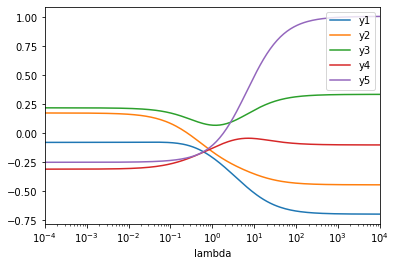

In [6]:
plt.ion()

# plot solution versus lambda
plt.plot(lambdas, x.T)
plt.xscale('log')
plt.xlabel('lambda')
plt.xlim((1e-4, 1e+4))
plt.legend(['y1','y2','y3','y4','y5'], loc='upper right')
plt.show()

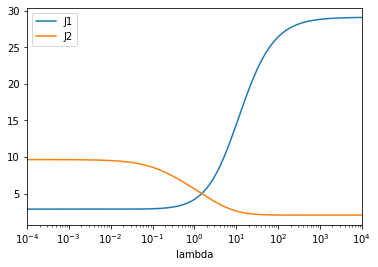

In [7]:
# plot two objectives versus lambda
plt.plot(lambdas, J1)
plt.plot(lambdas, J2)
plt.xscale('log')
plt.xlabel('lambda')
plt.xlim((1e-4, 1e+4))
plt.legend(['J1', 'J2'])
plt.show()

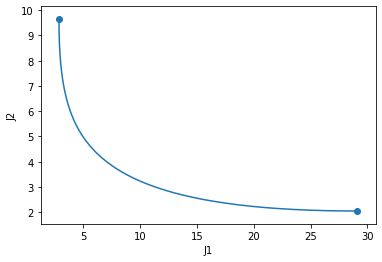

In [8]:
# plot tradeoff curve
plt.plot(J1, J2)
plt.xlabel('J1')
plt.ylabel('J2')

# add (single objective) end points to trade-off curve
x1 = np.linalg.lstsq(As[0], bs[0], rcond=None)[0]
x2 = np.linalg.lstsq(As[1], bs[1], rcond=None)[0]
J1 = [np.linalg.norm(As[0] @ x1 - bs[0])**2, np.linalg.norm(As[0] @ x2 - bs[0])**2]
J2 = [np.linalg.norm(As[1] @ x1 - bs[1])**2, np.linalg.norm(As[1] @ x2 - bs[1])**2]
plt.scatter(J1, J2)
plt.show()

# 15.2 Control

- decide on a set of *actions* or *inputs*, specified by an n-vector $x$
- result in some *outputs* or *effects*, given by an m-vector $y$
- inputs and outputs are related by affine input-output model
$$y = Ax+b$$
- $A$ and $b$ are known (from analytical models, data fitting . . . )
- the goal is to choose $x$ (which determines $y$), to optimize multiple objectives on $x$ and $y$


- typical primary objective: $J_1 = \|y − y^{des}\|^2$, where $y^{des}$ is a given desired or target output
- typical secondary objectives:
    - x is small: $J_2 = \|x\|^2$  (when x is energy, budget...)
    - x is not far from a nominal input: $J_2 = \|x − x^{nom}\|^2$

# 15.3 Estimation and inversion

- measurement model: $y = Ax + v$
- n-vector $x$ contains parameters we want to estimate (**goal of the application area of *estimation* (also called *inversion*)**)
- m-vector $y$ contains the measurements
- m-vector $v$ are (unknown) *noises* or *measurement errors*
- m × n matrix $A$ connects parameters to measurements
- basic least squares estimation: assuming $v$ is small (and $A$ has **independent columns**), we guess $x$ by minimizing $J_1 = \|Ax − y\|^2$

##  Regularized inversion

- Our **prior information** about $x$ enters in one or more *secondary objectives* can get better result
    - $J_2 = \|x\|^2$: $x$ should be not too large  ('Tikhonov regularization')
    - $J_2 = \|x - x^{prior}\|^2$: $x$ should be near $x^{prior}$
    - $J_2 = \|Dx\|^2$, where $D$ is the first difference matrix: $x$ should be smooth
- we minimize $J_1 + \lambda_2 J_2(x) + \cdots + \lambda_p J_p(x)$
- adjust $\lambda$ until you **like** the results
- curve of $\hat{x}(\lambda)$ versus $\lambda$ is called *regularization path*
- with Tikhonov regularization, works even when $A$ has dependent columns (e.g., when it is wide). Because the stacked matrix 
$$\tilde{A} = \begin{bmatrix} A \\ \sqrt{\lambda}I \end{bmatrix}$$
always has linearly independent columns

## Estimating a periodic time series

We start by loading the data, as a vector with hourly ozone levels, for a period of 14 days.

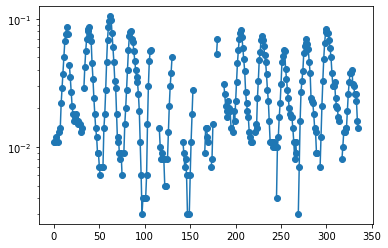

In [9]:
ozone = ozone_data() # a vector of length 14*24 = 336
k = 14
N = k * 24

plt.ion()
plt.plot(np.arange(N), ozone, 'o-')
plt.yscale('log')

Next, we make a periodic fit for the values λ = 1 and λ = 100.

In [10]:
A = np.vstack([np.eye(24) for i in range(k)])  # shape (336, 24)
# periodic difference matrix
D = -np.eye(24) + np.vstack((np.column_stack([np.zeros(23), np.eye(23)]), np.hstack([1, np.zeros(23)])))  # (24, 24)
ind = [k for k in range(len(ozone)) if ~np.isnan(ozone[k])]
As = [A[ind, :], D]  # (275, 24), (24, 24)
bs = [np.log(ozone[ind]), np.zeros(24)]  # (275,), (24,) 

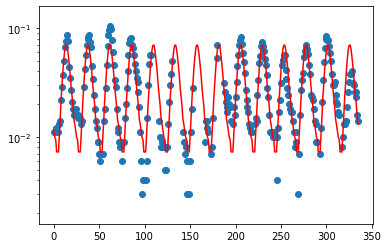

In [11]:
# solution for lambda = 1
lambdas = np.array([1, 1])

n = len(lambdas)
Atil = np.vstack([np.sqrt(lambdas[i])*As[i] for i in range(n)])  # (299, 24)
btil = np.hstack([np.sqrt(lambdas[i])*bs[i] for i in range(n)])  # (299,)
x = np.linalg.lstsq(Atil, btil, rcond=None)[0]  # (24,)

plt.scatter(np.arange(N), ozone)
plt.plot(np.arange(N), np.hstack([np.exp(x) for i in range(k)]), 'r')
plt.yscale('Log', basey=10)
plt.ylim(10**(-2.8), 10**(-0.8))
plt.show()

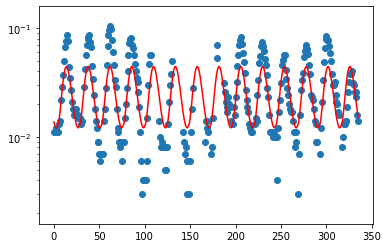

In [12]:
# solution for lambda = 100
lambdas = np.array([1, 100])
n = len(lambdas)
Atil = np.vstack([np.sqrt(lambdas[i])*As[i] for i in range(n)])
btil = np.hstack([np.sqrt(lambdas[i])*bs[i] for i in range(n)])
x = np.linalg.lstsq(Atil, btil, rcond=None)[0]

plt.scatter(np.arange(N), ozone)
plt.plot(np.arange(N), np.hstack([np.exp(x) for i in range(k)]), 'r')
plt.yscale('Log', basey=10)
plt.ylim(10**(-2.8), 10**(-0.8))
plt.show()

## Image de-blurring

- The vector $x$ is an image, and the matrix $A$ gives blurring, so $y = Ax+v$ is a blurred, noisy image.
- In least squares image deblurring we form an estimate $\hat{x}$ by minimizing
$$ \| Ax - y \|^2 + \lambda ( \| D_h x \|^2 + \| D_v x \|^2) $$
$D_v$, $D_h$ are vertical and horizontal differencing operations

- suppose the vector $x$ has length MN and contains the pixel intensities of an M × N image $X$ stored **column-wise**.
- Let $D_h$ be the M(N − 1) × MN matrix
$$
D_h = \begin{bmatrix}
-I & I & 0 & \cdots & 0 & 0 & 0 \\
0 & -I & I & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots &  & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & -I & I & 0 \\
0 & 0 & 0 & \cdots & 0 & -I & I
\end{bmatrix}
$$
where all blocks have size M × M
- let $D_v$ be the (M − 1)N × MN matrix
$$
D_v = \begin{bmatrix}
D & 0 & \cdots & 0 \\
0 & D & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & D
\end{bmatrix}
$$
where each of the N diagonal blocks $D$ is an (M − 1) × M difference matrix
$$
D = \begin{bmatrix}
-1 & 1 & 0 & \cdots & 0 & 0 & 0 \\
0 & -1 & 1 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots &  & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & -1 & 1 & 0 \\
0 & 0 & 0 & \cdots & 0 & -1 & 1
\end{bmatrix}
$$

# 15.4 Regularized data fitting

- Regularization is another way to avoid over-fitting
- Regularization is also called *de-tuning*, *shrinkage*, or *ridge regression*

## Motivation

- consider data fitting model (of relationship $y \approx f(x)$)
$$ \hat{f}(x) = \theta_1 f_1(x) + \theta_2 f_2(x) + \cdots + \theta_p f_p(x)$$
with $f_1(x) = 1$
- $θ_i$ is the sensitivity of $\hat{f}(x)$ to $f_i(x)$, so large $θ_i$ means the model is very sensitive to $f_i(x)$
- $θ_1$ is an exception, since $f_1(x) = 1$ never varies
- so, we don't want $θ_2, \ldots , θ_p$ to be too large (shrinkage)

---

- suppose we have data $(x1, y1), \ldots, (x_N, y_N)$
- express fitting error as $A\theta − y$
- *regularized data fitting*: choose $\theta$ to minimize
$$
\|A\theta - y\|^2 + \|\theta_{2:p}\|^2
$$
where $\lambda > 0$ is called the *regularization parameter*
- for regression model $\hat{y} = X^T \beta + v\mathbf{1}$, we minimize
$$
\|X^T\beta + v\mathbf{1} − y\|^2 + \lambda \|\beta\|^2
$$
Choosing $\beta$ to minimize this weighted objective is called *ridge regression*
- choose $\lambda$ by validation on a test set

## Example

We fit a model
$$
\hat{f}(x) = \sum^5_{k=1} \theta_k f_k(x)
$$
with basis function $f_1(x) = 1$ and $f_{k+1}(x) = sin(\omega_k x + \phi_k)$ for $k = 1, \ldots, 4$ to $N = 20$ data points.
We use the values of $\omega_k$, $\phi_k$ given in the text. We fit the model by solving a sequence of regularized least squares problems with objective
$$
\sum^N_{i=1}{( y^{(i)} -  \sum^5_{k=1}{\theta_k f_k(x^{(i)})} )^2} + \lambda \sum^5_{k=2}\theta_k^2
$$

In [13]:
#Import data as vectors xtrain, ytrain, xtest, ytest
D = regularized_fit_data()
xtrain = D['xtrain']
ytrain = D['ytrain']
xtest = D['xtest']
ytest = D['ytest']

print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(10,)
(10,)
(20,)
(20,)


In [14]:
N = len(ytrain)
Ntest = len(ytest)
p = 5
omega = np.array([13.69, 3.55, 23.25, 6.03])
phi = np.array([0.21, 0.02, -1.87, 1.72])

A = np.column_stack((np.ones(N), np.sin(np.outer(xtrain, omega) + np.outer(np.ones(N), phi))))
Atest = np.column_stack((np.ones(Ntest), np.sin(np.outer(xtest, omega) + np.outer(np.ones(Ntest), phi))))

# initialize different lambda and empty array for collecting error and theta
npts = 100
lambdas = np.power(10, np.linspace(-6, 6, npts))
err_train = np.zeros(npts)
err_test = np.zeros(npts)
thetas = np.zeros((p, npts))

# stacked matrix and vector
As = [A, np.column_stack([np.zeros(p-1), np.eye(p-1)])]
bs = [ytrain, np.zeros(p-1)]

In [15]:
# solve
for k in range(npts):
    lam = [1, lambdas[k]]
    n = len(lam)
    Atil = np.vstack([np.sqrt(lam[i])*As[i] for i in range(n)])
    btil = np.hstack([np.sqrt(lam[i])*bs[i] for i in range(n)])
    theta = np.linalg.lstsq(Atil, btil, rcond=None)[0]  # np.linalg.inv(Atil.T @ Atil) @ (Atil.T @ btil)
    err_train[k] = (sum((ytrain - A @ theta)**2)/len(ytrain))**0.5
    err_test[k] = (sum((ytest - Atest @ theta)**2)/len(ytest))**0.5
    thetas[:, k] = theta

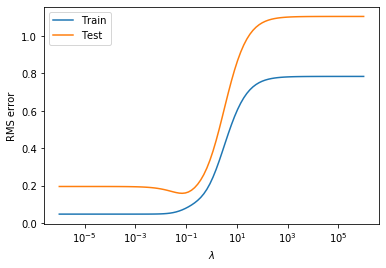

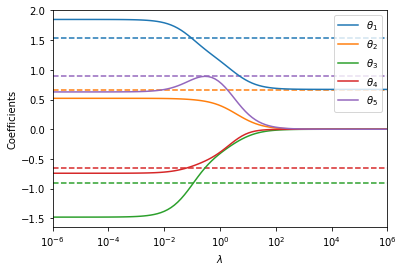

In [16]:
plt.ion()

# plot RMS errors
plt.plot(lambdas, err_train.T)
plt.plot(lambdas, err_test.T)
plt.xscale('Log')
plt.xlabel(r'$\lambda$')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylabel('RMS error')
plt.show()

# Plot coefficients
plt.plot(lambdas, thetas.T)
for coef, color in zip([1.54, 0.66, -0.9, -0.66, 0.89], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    plt.hlines([coef], 1e-6, 1e6, color=color, linestyles='dashed')
plt.xscale('Log')
plt.xlabel(r'$\lambda$')
plt.ylabel('Coefficients')
plt.xlim((1e-6, 1e6))
plt.legend([r'$\theta_1$', r'$\theta_2$', r'$\theta_3$', r'$\theta_4$', r'$\theta_5$'], loc='upper right')
plt.show()

# 15.5 Complexity

- using the QR factorization to solve the $\tilde{A}x = \tilde{b}$ least squares problem
- complexity is order $mn^2$ flops, where $m = m_1+ \cdots + m_k$ is the sum of heights of the matrices $A_1, \ldots , A_k$
- for L different values of the weights (i.e. different $\lambda_i$), the total complexity is order $Lmn^2$ flops

## Gram caching

- from the formula for the minimizer of the weighted sum objective,
$$
\hat{x} = (\lambda_1 A^T_1 A_1 + \cdots+ \lambda_k A^T_k A_k)^{−1} (\lambda_1 A^T_1 b_1 + \cdots + \lambda_k A^T_k A_k)
$$
- compute $\hat{x}$ by forming the Gram matrices $G_i =A^T_i A_i$ associated with the matrices $A_i$, along with the vectors $h_i = A^T_ib_i$.
- forming the weighted sums
$$G = \lambda_1 G_1 + \cdots + \lambda_k G_k,\ h = \lambda_1 h_1 + \cdots + \lambda_k h_k,$$
and finally, solving the n × n set of equations $G\hat{x} = h$
- Forming $G_i$ and $h_i$ costs $m_i n^2$ and $2m_i n$ flops, so forming all $G_i$ and $h_i$ cost $m n^2$ (ignore $2m_i n$)
- Forming the weighted sums G and h costs $2kn^2$ flops.
- Solving $G\hat{x} = h$ costs order $2n^3$ flops
- Gram caching: computing $G_i$ (and $h_i$) just once, and reusing these matrices and vectors for the L different choices of weights, This leads to a complexity of
$$ mn^2 + L(k + 2n)n^2$$

## The kernel trick

- special case, where the m × n matrix $A$ is **wide**, i.e., m < n, and $\lambda$ > 0.
$$
J = \|Ax − b\|^2 + \lambda \|x − x^{des}\|^2
$$
- The associated (m + n) × n stacked matrix always has linearly independent columns
$$ \tilde{A} = \begin{bmatrix} A \\ \sqrt{\lambda} I \end{bmatrix} $$
- Using the *QR factorization* to solve the stacked least squares problem requires $2(m + n)n^2$ flops, which grows like $n^3$
---
kernel trick

- minimizer of J is 
$$
\begin{align}
\hat{x} &= (A^T A + \lambda I)^{−1} (A^T b + \lambda x^{des}) \\
&= (A^T A + \lambda I)^{−1} (A^T b + (\lambda I + A^T A) x^{des} - (A^T A) x^{des}) \\
&= (A^T A + \lambda I)^{−1} A^T (b - A x^{des}) + x^{des}
\end{align}
$$
The matrix inverse here has size n × n
- use the identity
$$
(A^T A + \lambda I)^{−1} A^T = A^T (A A^T + \lambda I)^{−1}
$$
which holds for any matrix $A$ and any $\lambda$ > 0
- the minimizer of J become
$$
\hat{x} = A^T (A A^T + \lambda I)^{−1} (b - A x^{des}) + x^{des}
$$
- compute the term $(A A^T + \lambda I)^{−1} (b - A x^{des})$ by computing the QR factorization of the (m + n) × m matrix
$$
\bar{A} = \begin{bmatrix} A^T \\ \sqrt{\lambda} I \end{bmatrix}
$$,
which has a cost of $2(m + n)m^2$ flops.
- The complexity can then be expressed as
$$
(m + n) \text{min} \lbrace m^2, n^2 \rbrace \approx \text{min}\lbrace mn^2, nm^2 \rbrace = (\text{max}\lbrace m, n \rbrace)(\text{min}\lbrace m, n \rbrace)^2.
$$

We will compute $\hat{x}$ in two ways. First, the naive way, and then, using the kernel trick. We use the fact that if
$$
\begin{bmatrix}
A^T \\
\sqrt{\lambda}I
\end{bmatrix}
= QR
$$
, then
$$
(A A^T + \lambda I)^{−1} = (R^TQ^TQR)^{−1} = R^{−1}R^{−T}
$$

In [17]:
m = 100
n = 5000
A = np.random.normal(size = (m,n))
b = np.random.normal(size = m)
xdes = np.random.normal(size = n)
lam = 2.0

In [20]:
# Find x that minimizes ||Ax - b||^2 + lambda ||x||^2
start = time.time()
xhat1 = solve_via_backsub(np.vstack((A, np.sqrt(lam)*np.eye(n))), np.hstack((b.T, np.sqrt(lam)*xdes)))
end = time.time()
print('xhat1 time:', end - start)

Vectors are linearly independent.
xhat1 time: 443.3004653453827


In [23]:
# Now use kernel trick
start = time.time()
Q, R = QR_factorization(np.vstack((A.T, np.sqrt(lam)*np.eye(m))))
xhat2 = A.T @ (solve_via_backsub(R, solve_via_backsub(R.T, (b-A @ xdes))) ) + xdes
end = time.time()
print('xhat2 time:', end - start)

Vectors are linearly independent.
Vectors are linearly independent.
Vectors are linearly independent.
xhat2 time: 0.41614317893981934


In [24]:
# compare solutions
np.linalg.norm(xhat1 - xhat2)

5.7686645429582975e-12